In [0]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
from torchsummary import summary
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Batch generator

In [0]:
def batch_generator(X, y, batch_size):
    np.random.seed(42)
    perm = np.random.permutation(len(X))

    num_samples = len(X)
    num_batches = num_samples // batch_size if num_samples % batch_size == 0 else num_samples // batch_size + 1

    X = torch.from_numpy(np.array([X[i].numpy() for i in perm]))
    y = torch.from_numpy(np.array([y[i].numpy() for i in perm]))

    for i in range(num_batches):
        if i == num_batches - 1: #if the last one
            batch_x = torch.FloatTensor(X[batch_size * i :])
            batch_y = torch.LongTensor(y[batch_size * i :])
        else:
            batch_x = torch.FloatTensor(X[batch_size * i : batch_size * (i+1)])
            batch_y = torch.LongTensor(y[batch_size * i : batch_size * (i+1)])
        
        yield(batch_x, batch_y)

##Classification model

####data preprocessing

In [4]:
data = pd.read_csv('/content/drive/My Drive/2019-2020 Deep Learning School/Datasets/sky_data.csv')
data['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

In [0]:
#each object has 10 features
feature_columns = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'camcol', 'field']
target_column = 'class'
target_mapping = {'GALAXY': 0,'STAR': 1,'QSO': 2}

def Reset_data():
    X = data[feature_columns]
    y = data[target_column]
    y = y.map(target_mapping)

    X = (X - X.mean()) / X.std() #normalization

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    X_train = torch.FloatTensor(X_train.values)
    y_train = torch.LongTensor(y_train.values)
    X_test = torch.FloatTensor(X_test.values)
    y_test = torch.LongTensor(y_test.values)

    return X_train, X_test, y_train, y_test

####model building & training

In [0]:
torch.manual_seed(42) 
np.random.seed(42)
model = nn.Sequential(
    nn.Linear(10, 50),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.BatchNorm1d(50),
    nn.Linear(50, 100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.BatchNorm1d(100),
    nn.Linear(100, 3)
)
    
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [0]:
def train(num_epoch):
    
    train_losses = []
    test_losses = []

    for i in range(num_epoch):
        for X_batch, y_batch in batch_generator(X_train, y_train, 500):
            model.train(True)

            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss_fn(y_pred, y_batch).item())

            model.train(False)
            y_pred_test = model(X_test)

            test_losses.append(loss_fn(y_pred_test, y_test).item())

    return train_losses, test_losses

In [0]:
def plotTrainTestLosses(train_losses, test_losses):
    plt.figure(figsize=(8,12))
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
    plt.legend()
    plt.show()

####showtime

In [0]:
model.train(False)
X_train, X_test, y_train, y_test = Reset_data()
train_losses, test_losses = train(20)

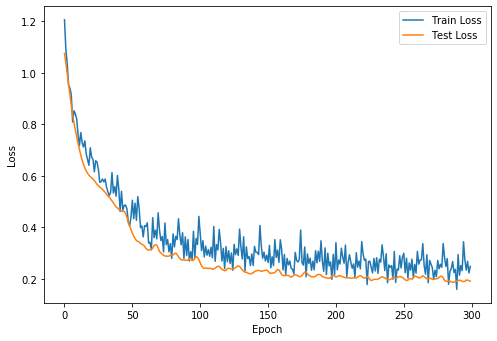

In [10]:
plotTrainTestLosses(train_losses, test_losses)

Mean prediction of appertaining to class 0:


In [11]:
model(X_test)[:, 0].mean().item()

1.6131412982940674

##Improving the model

In [0]:
def get_model():
    torch.manual_seed(42)   
    np.random.seed(42)

    model = nn.Sequential(
        #nn.Dropout(p=0.5),  # Dropout before the linear layers is useless
        nn.Linear(10, 50),   # Don't forget that the shapes must match
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(50, 200),
        #nn.Softmax(),       # It's much better to use ReLU, not Softmax
        nn.ReLU(),
        nn.Linear(200, 200),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(200, 3),   # Last layer doesn't need an activation because
                            # of CrossEntropy.

        #nn.Dropout(p=0.5)   # Dropout after the linear layers is useless
    )

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    print('Model reset')

    return model, loss_fn, optimizer

Model reset


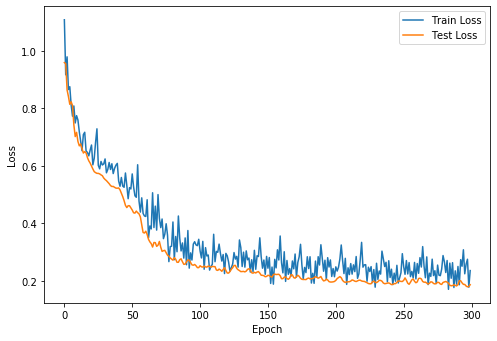

Mean Loss:  0.2951008070508639


In [13]:
X_train, X_test, y_train, y_test = Reset_data()
model, loss_fn, optimizer = get_model()

train_losses, test_losses = train(20)
plotTrainTestLosses(train_losses, test_losses)
print('Mean Loss: ', np.mean(test_losses))

Mean Loss Records:
```
initial _________________ 0.29536782259742417
2 dropouts ______________ 0.7637741301457087
1st dropout _____________ 0.7221721502145132
2nd dropout _____________ 0.41572329943378766
0 dropouts ______________ 0.3633407831688722
relu instead of softmax _ 0.2951008070508639
```

##Evaluating effectivenes of adding blocks into the model

Is it true that with adding more blocks into our model its metrics become better? Intuitively, not always. But let's just prove it.



In [0]:
# To ensure that the blocks remain unchanged
def get_blocks():
    head = nn.Sequential(
        nn.Linear(len(feature_columns), 100),
        nn.ReLU(),
        nn.Dropout(0.5)
    )
    block = nn.Sequential(
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.BatchNorm1d(100)
    )
    tail = nn.Sequential(
        nn.Linear(100, 3)
    )
    return head, block, tail

def get_newblock():
    block = nn.Sequential(
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.BatchNorm1d(100)
    )
    return block

def assemble_model(k): #get model with k blocks inserted
    head, block, tail = get_blocks()
    body = [head]
    for i in range(k):
        block = get_newblock()
        torch.manual_seed(42)
        np.random.seed(42)
        body.append(block)
    body.append(tail)

    model = nn.Sequential(*body)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [33]:
# Now let's compare [num] differnt models. 
# Beware: don't make [num] too big, it will take a long time to compute
num = 6
minloss = []
all_loss = []
for k in range(num):
    print('====== assembling a model with', k, 'blocks ======')

    X_train, X_test, y_train, y_test = Reset_data()
    torch.manual_seed(42)
    np.random.seed(42)
    model, loss_fn, optimizer = assemble_model(k)
    model.train(False)

    train_losses, test_losses = train(20)
    print('| Minimum loss: ', np.min(test_losses), '|')
    print('| Mean    loss: ', np.mean(test_losses), '|')

    minloss.append(np.min(test_losses))
    all_loss.append(test_losses)

====== assembling a model with 0 blocks ======
| Minimum loss:  0.30202415585517883 |
| Mean    loss:  0.37859691003958384 |
====== assembling a model with 1 blocks ======
| Minimum loss:  0.17353589832782745 |
| Mean    loss:  0.28692961171269415 |
====== assembling a model with 2 blocks ======
| Minimum loss:  0.16634449362754822 |
| Mean    loss:  0.26736170987288155 |
====== assembling a model with 3 blocks ======
| Minimum loss:  0.1658417284488678 |
| Mean    loss:  0.26790610363086065 |
====== assembling a model with 4 blocks ======
| Minimum loss:  0.17051586508750916 |
| Mean    loss:  0.27016043702761333 |
====== assembling a model with 5 blocks ======
| Minimum loss:  0.1700384020805359 |
| Mean    loss:  0.2811597800751527 |


####show-time

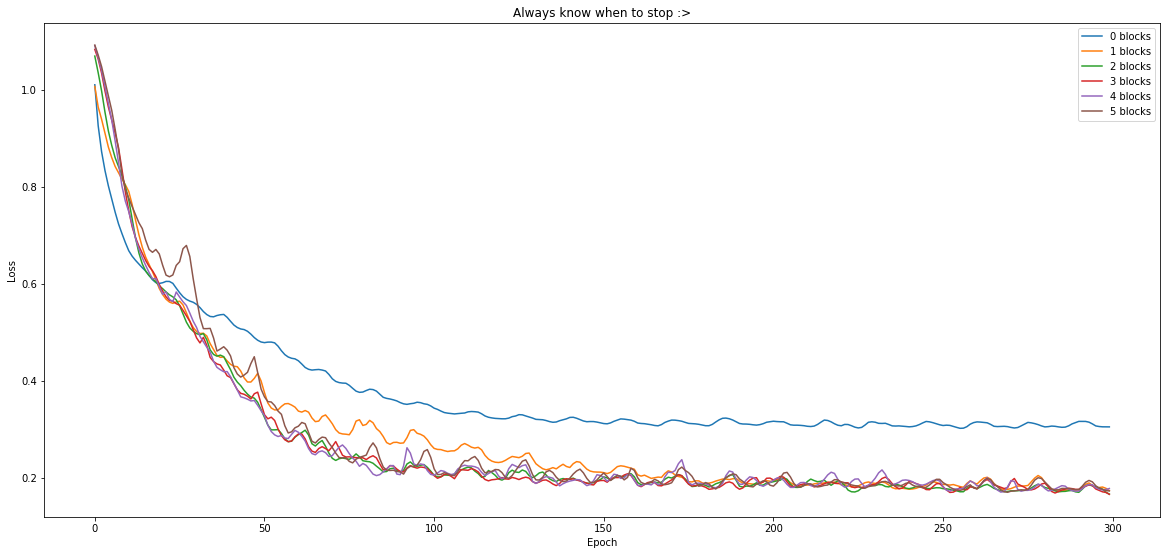

In [34]:
plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
for i in range(num):
    plt.plot(range(len(all_loss[i])), all_loss[i], label=str(i)+' blocks')

plt.legend()
plt.title('Always know when to stop :>')
plt.show()

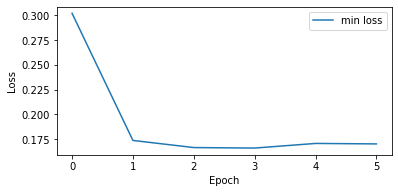

In [37]:
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(num), minloss, label='min loss')

plt.legend()
plt.show()

The best number of blocks to use:

In [24]:
print(minloss.index(min(minloss)))

3
